In this iPython notebook, we will featurize MOR ligand binding simulation by pairwise distances between the ligand and different receptor residues. We will then perform tICA and prospectively build an MSM. 

In [5]:
from PDB_Order_Fixer import PDB_Order_Fixer
import mdtraj as md
import os
import numpy as np
import h5py

import datetime
import glob
import copy
from functools import partial 
import operator
import time

import random 
import subprocess
from subprocess import Popen
import sys
from io_functions import *
from custom_clusterer import *
from custom_tica import *
from custom_featurizer import *
from pdb_editing import *
from analysis import *
from io_functions import *
#from topology_fixing import *
from subsampling import *
from conversions import *
from custom_msm import *
from grids import *

In [6]:
from detect_intermediates import *
from interpret_tICs import *

In [7]:
from mor_ligand_atom_residue_feature_types import *
from get_variable_names import *
from mor_ligand_atom_residue_tica_config import *
from residue import Residue, Atom

In [8]:
(active_ref_dir, inactive_ref_dir, simulation_ref_dir, scripts_dir,
          ligand_dir, agonist_dir, inverse_agonist_dir, biased_agonist_dir, ref_receptors_dir, whole_trajectory_pnas,
          sasa_file) = get_base_files(base)

tica_dir = get_tica_dir(base, is_sparse, lag_time, n_components, feature_name, 
                                 wolf_string, shrinkage_string, rho_string)
ori_tica_dir = copy.deepcopy(tica_dir)
features_dir = get_features_dir(base, feature_name)

landmarks_dir = get_landmarks_dir(tica_dir)
analysis_dir = get_analysis_dir(tica_dir, n_clusters, sampling_method)
gmm_dir = get_gmm_dir(tica_dir)
rf_dir = get_rf_dir(tica_dir)


ref_tica_dir, ref_tica_coords = get_ref_tica_dirs(tica_dir)

graph_file = get_graph_file(tica_dir, msm_lag_time, n_clusters)

pnas_titles =  ["tm6_tm3_dist", "rmsd_npxxy_inactive", "rmsd_npxxy_active", "rmsd_connector_inactive", "rmsd_connector_active"]
pnas_features_dir = analysis_dir


(clusterer_dir, msm_model_dir, macrostate_dir, features_known, model_dir, projected_features_dir,
         projection_operator_dir, ktica_fit_model_filename, ktica_projected_data_filename, nystroem_data_filename,
         mutual_information_csv, pearson_csv) = get_tica_files(base, tica_dir, n_clusters, msm_lag_time, n_macrostates)

(standardized_features_dir, feature_residues_csv, feature_residues_pkl,
          contact_csv, ref_features_dir) = get_feature_files(features_dir)

(kmeans_csv, tica_coords_csv, features_csv, active_rmsd_dir, inactive_rmsd_dir, active_pnas_dir, inactive_pnas_joined, active_pnas_joined,
        clusters_map_file, ktica_clusters_map_file, analysis_file, combined_file, docking_summary, docking_joined, docking_z_scores_csv,
        aggregate_docking, aggregate_docking_joined, docking_pnas_joined, aggregate_docking_pnas, aggregate_docking_pnas_joined, docking_multiple_ligands,
        docking_distances_file, docking_pdf, mmgbsa_docking_distances, pnas_coords, mmgbsa_dir, mmgbsa_csv, mmgbsa_pdf, aggregate_mmgbsa,
        aggregate_mmgbsa_joined, aggregate_mmgbsa_pnas_joined, mmgbsa_z_scores_csv, active_clusters_csv, intermediate_clusters_csv,
        inactive_clusters_csv, pnas_clusters_averages, tica_clusters_averages, tica_classes_csv, tica_samples_csv, subgraph_save_base,
        degree_save_base, degree_map_csv, degree_z_map_csv, aggregate_docking_pnas_degree_z_joined, tic_residue_csv, feature_coefs_csv,
        duplicated_feature_coefs_csv) = get_analysis_files(analysis_dir, n_clusters, tica_dir, tica_dir, sampling_method, n_samples, precision,
                                                           msm_lag_time)

(inactive_pnas_distances_dir, active_pnas_distances_dir, active_pnas_all_distances_dir,
          inactive_pnas_distances_new_csv, active_pnas_distances_new_csv, active_pnas_joined, active_pnas_means, pnas_coords_dir,
          pnas_coords_csv, pnas_all_coords_csv, pnas_coords_hexbin_dir, pnas_coords_co_crystallized_docking_dir,
          pnas_coords_active_colors_dir, user_defined_features_file, reaction_coordinates_trajs_file) = get_pnas_files(whole_trajectory_pnas, pnas_features_dir)

features_dir = get_features_dir(base, feature_name)



graph_file = get_graph_file(tica_dir, msm_lag_time, n_clusters)
(scripts_dir, pymol_fixpdb_dir) = get_script_dir(scripts_dir)
(save_dir, reimaged_dir, mae_dir, combined_reimaged_dir, grid_dir, docking_dir) = get_docking_dirs(tica_dir, n_clusters, n_components, n_samples, sampling_method, precision)


/home/enf/quintin/Post_Process/GPCR/MOR/LIG_path/BU_path/featuresprotein-ligand_protein-protein_contacts-all_residues_4dkl_5c1m_under_cutoff6A
/home/enf/quintin/Post_Process/GPCR/MOR/LIG_path/BU_path/featuresprotein-ligand_protein-protein_contacts-all_residues_4dkl_5c1m_under_cutoff6A


In [13]:
compute_user_defined_features_wrapper(traj_dir, traj_ext, inactive_dir, active_dir, None, feature_name_residues_dict, user_defined_features_file)

Saving "/home/enf/quintin/Post_Process/GPCR/MOR/LIG_path/BU_path/all_pnas_features/user_defined_features.h5"... (<type 'list'>)
featurizing /home/enf/quintin/Post_Process/GPCR/MOR/LIG_path/BU_path/h5_trajectories/Rep_0-0.h5
featurizing /home/enf/quintin/Post_Process/GPCR/MOR/LIG_path/BU_path/h5_trajectories/Rep_0-2.h5
featurizing /home/enf/quintin/Post_Process/GPCR/MOR/LIG_path/BU_path/h5_trajectories/Rep_1-0.h5
featurizing /home/enf/quintin/Post_Process/GPCR/MOR/LIG_path/BU_path/h5_trajectories/Rep_1-2.h5
featurizing /home/enf/quintin/Post_Process/GPCR/MOR/LIG_path/BU_path/h5_trajectories/Rep_2-0.h5
featurizing /home/enf/quintin/Post_Process/GPCR/MOR/LIG_path/BU_path/h5_trajectories/Rep_2-2.h5
featurizing /home/enf/quintin/Post_Process/GPCR/MOR/LIG_path/BU_path/h5_trajectories/Rep_3-0.h5
featurizing /home/enf/quintin/Post_Process/GPCR/MOR/LIG_path/BU_path/h5_trajectories/Rep_3-2.h5
featurizing /home/enf/quintin/Post_Process/GPCR/MOR/LIG_path/BU_path/h5_trajectories/Rep_4-0.h5
featuriz

In [14]:
plot_columns(pnas_features_dir, user_defined_features_file, titles = feature_name_residues_dict.keys(), tICA=False, scale=1.0, refcoords_file=None)

loading "/home/enf/quintin/Post_Process/GPCR/MOR/LIG_path/BU_path/all_pnas_features/user_defined_features.h5"...
()
None
Done plotting columns


In [45]:
import pickle
with open(feature_residues_pkl, "rb") as f:
    feature_residues = pickle.load(f)
print(feature_residues[0])
print(feature_residues[0][0].__dict__)
print(feature_residues[0][1].__dict__)

[Ile198, ILE193]
{'res_name': 'Ile198', 'resSeq': 198, 'ballosteros_weinstein': None, 'chain_id': 'R', 'chain_name': None}
{'res_name': 'ILE193', 'resSeq': 193, 'ballosteros_weinstein': None, 'chain_id': 'R', 'chain_name': None}


In [42]:
features = np.concatenate(load_file_list(get_trajectory_files(features_dir, ".dataset")))

None
None
['/home/enf/quintin/Post_Process/GPCR/MOR/LIG_path/BU_path/featuresprotein-ligand_protein-protein_contacts-all_residues_4dkl_5c1m_under_cutoff6A/Rep_0-0.dataset', '/home/enf/quintin/Post_Process/GPCR/MOR/LIG_path/BU_path/featuresprotein-ligand_protein-protein_contacts-all_residues_4dkl_5c1m_under_cutoff6A/Rep_0-1.dataset', '/home/enf/quintin/Post_Process/GPCR/MOR/LIG_path/BU_path/featuresprotein-ligand_protein-protein_contacts-all_residues_4dkl_5c1m_under_cutoff6A/Rep_0-2.dataset', '/home/enf/quintin/Post_Process/GPCR/MOR/LIG_path/BU_path/featuresprotein-ligand_protein-protein_contacts-all_residues_4dkl_5c1m_under_cutoff6A/Rep_0-3.dataset', '/home/enf/quintin/Post_Process/GPCR/MOR/LIG_path/BU_path/featuresprotein-ligand_protein-protein_contacts-all_residues_4dkl_5c1m_under_cutoff6A/Rep_1-0.dataset', '/home/enf/quintin/Post_Process/GPCR/MOR/LIG_path/BU_path/featuresprotein-ligand_protein-protein_contacts-all_residues_4dkl_5c1m_under_cutoff6A/Rep_1-1.dataset', '/home/enf/quinti

In [23]:
user_defined_features = np.concatenate(verboseload(user_defined_features_file))

loading "/home/enf/quintin/Post_Process/GPCR/MOR/LIG_path/BU_path/all_pnas_features/user_defined_features.h5"...


In [22]:
from scipy.stats import pearsonr

In [43]:
correlation_features_pnas = [pearsonr(user_defined_features[:,0], features[:,i])[0] for i in range(0,np.shape(features)[1])]

In [46]:
correlation_feature_tuples = [(np.abs(correlation_features_pnas[i]), feature_residues[i]) for i in range(0,len(correlation_features_pnas))]

In [47]:
from operator import itemgetter
correlation_feature_tuples = sorted(correlation_feature_tuples, key=itemgetter(0), reverse=True)

In [48]:
correlation_feature_tuples

[(0.93636888, [ASN332, ALA337]),
 (0.84082454, [ASN332, PHE338]),
 (0.77148718, [LEU331, TYR336]),
 (0.76359761, [ASN332, LEU110]),
 (0.73988569, [ASN332, ALA111]),
 (0.73852921, [PHE338, PRO333]),
 (0.72981811, [ALA337, PRO333]),
 (0.67499632, [ASP114, TYR336]),
 (0.6482836, [LEU339, PRO333]),
 (0.58884472, [ALA111, TYR336]),
 (0.53096151, [ASN332, VAL288]),
 (0.51889026, [TYR336, THR103]),
 (0.5058853, [ASN86, TYR336]),
 (0.50088704, [VAL334, LEU339]),
 (0.47336939, [LEU335, LEU331]),
 (0.45397076, [VAL89, VAL334]),
 (0.41375354, [ASN332, ASN86]),
 (0.40489903, [MET161, TYR336]),
 (0.4007619, [VAL334, ASP340]),
 (0.39925784, [ASN332, LEU335]),
 (0.39765066, [VAL334, PHE338]),
 (0.38632229, [LYS344, TYR336]),
 (0.37897024, [GLU341, TYR336]),
 (0.37576866, [ARG165, TYR336]),
 (0.37286612, [VAL89, PRO333]),
 (0.37011725, [LEU335, MET281]),
 (0.3679398, [Asn150, ASP114]),
 (0.35910341, [VAL285, TYR336]),
 (0.35908344, [ASP340, TYR336]),
 (0.33375961, [LEU339, TYR336]),
 (0.32870418, [ASN

In [73]:
ligand_features = [cor_tup for cor_tup in correlation_feature_tuples if "Lig" in str(cor_tup[1][0]) or "LIG" in str(cor_tup[1][1])]
ligand_features

[(0.2007708, (Lig900-N1, Gly213)),
 (0.19909361, (Lig900-N1, Ile215)),
 (0.19879368, (Lig900-N1, Pro134)),
 (0.19604456, (Lig900-N1, Met130)),
 (0.19327457, (Lig900-N1, Ser214)),
 (0.18740113, (Lig900-N1, Thr132)),
 (0.18556841, (Lig900-N1, Phe135)),
 (0.17696255, (Lig900-N1, Leu129)),
 (0.17596191, (Lig900-N1, Trp133)),
 (0.17546183, (Lig900-N1, Gly136)),
 (0.17430569, (Lig900-N1, Gly131)),
 (0.1679281, (Lig900-C7, Gly213)),
 (0.16720986, (Lig900-N1, Tyr210)),
 (0.16610812, (Lig900-N1, Lys209)),
 (0.16262782, (Lig900-N1, Val126)),
 (0.16070707, (Lig900-N1, Thr208)),
 (0.15946624, (Lig900-C7, Ser214)),
 (0.15693171, (Lig900-N1, Ile302)),
 (0.15325119, (Lig900-N1, Asn137)),
 (0.15176973, (Lig900-N1, Asn127)),
 (0.15043414, (Lig900-N1, Ile69)),
 (0.14622188, (Lig900-N1, Asp216)),
 (0.14562464, (Lig900-C7, Ile215)),
 (0.14213537, (Lig900-N1, Leu305)),
 (0.140633, (Lig900-N1, Gln212)),
 (0.1398644, (Lig900-C7, Tyr210)),
 (0.13890351, (Lig900-N1, Tyr128)),
 (0.13818544, (Lig900-C7, Lys209))

In [70]:
non_npxxy_features = [cor_tup for cor_tup in correlation_feature_tuples if cor_tup[1][0].resSeq not in range(330,340) and cor_tup[1][1].resSeq not in range(330,340)]
non_npxxy_features

[(0.3679398, [Asn150, ASP114]),
 (0.29809493, [MET281, THR103]),
 (0.26242697, [ARG179, ILE167]),
 (0.25959364, [Asn230, Leu305]),
 (0.25490633, [ASN104, MET281]),
 (0.25331736, [SER329, Gly325]),
 (0.23044957, [ILE290, ILE155]),
 (0.22967634, [LEU110, ASP114]),
 (0.22481656, [LEU110, PHE289]),
 (0.22338609, [Leu116, Asn150]),
 (0.21938939, [SER154, ASP114]),
 (0.21747774, [Lys233, Ala304]),
 (0.21583658, [SER329, Trp293]),
 (0.21568213, [Asn230, Ala304]),
 (0.2146319, [Gly136, Trp133]),
 (0.21407045, [VAL169, THR279]),
 (0.21383312, [Ala117, Ile146]),
 (0.21202594, [PHE178, ASN183]),
 (0.21185933, [Ile298, Phe237]),
 (0.21046482, [ARG179, ARG165]),
 (0.20640753, [ASN328, ILE290]),
 (0.20313646, [ARG277, LYS344]),
 (0.2017784, [Lys233, Lys303]),
 (0.2007708, (Lig900-N1, Gly213)),
 (0.20052969, [ILE290, LEU158]),
 (0.19994062, [Pro134, Val126]),
 (0.19909361, (Lig900-N1, Ile215)),
 (0.19879368, (Lig900-N1, Pro134)),
 (0.19772117, [Ser125, Ser76]),
 (0.19728352, [Cys292, TYR326]),
 (0.19

In [54]:
import pandas as pd
features_df = pd.DataFrame(features, columns=feature_residues)

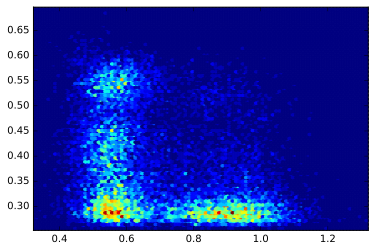

['rmsd_npxxy_active', 'rmsd_npxxy_inactive', 'tm6_tm3_dist']

In [72]:
%matplotlib inline

import matplotlib.pyplot as plt

import matplotlib as mpl
from seaborn.apionly import set_palette
from IPython.display import set_matplotlib_formats

# configure plotting
set_matplotlib_formats('pdf', 'svg')
set_palette('Set1', n_colors=15, desat=None)
plt.hexbin(user_defined_features[:,0], features_df[tuple(non_npxxy_features[0][1])])
plt.show()
sorted(feature_name_residues_dict.keys())

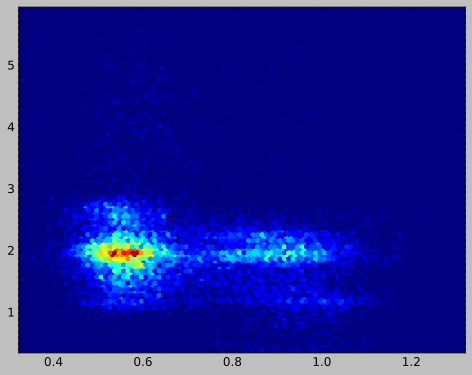

In [67]:
plt.hexbin(user_defined_features[:,0], features_df[tuple(ligand_features[0][1])])
plt.show()

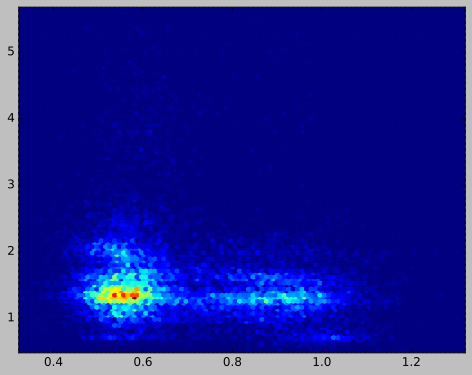

In [68]:
plt.hexbin(user_defined_features[:,0], features_df[tuple(ligand_features[1][1])])
plt.show()

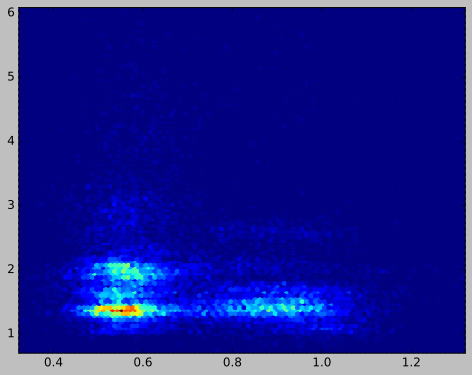

In [69]:
plt.hexbin(user_defined_features[:,0], features_df[tuple(ligand_features[2][1])])
plt.show()